# This notebook looks at loading image chips, resizing appropriately, and storing as PyTorch data loaders. Or... at least a set of tensors. DataLoader is preferable.

## Import some required libraries

In [1]:
import torch, torchvision
import glob
import os,sys
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import rasterio
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import random

%matplotlib inline



## load the image file names for training/testing

In [4]:
# specify the image directories for dg and planet data
dg_dir = '/media/jomc9287/Data/pytorch_SSIR_jdiaz/dg_sr_chips'
planet_dir = '/media/jomc9287/Data/pytorch_SSIR_jdiaz/planet_sr_chips'

# get the tif file paths
dg_files = glob.glob(dg_dir + '/*.tif')
planet_files = glob.glob(planet_dir + '/*.tif')

# ensure these are the same lengths
assert(len(dg_files) == len(planet_files))

# get the values for train/test/validation splits
file_len = len(dg_files)
train_len = int(file_len*.6)
test_len = int((file_len - train_len) / 2 )
validation_len = file_len - train_len - test_len

train_list = list(range(train_len))
test_list = list(range(train_len, train_len+test_len+1))
val_list = list(range(train_len+test_len, file_len))

print(train_list[0], train_list[-1])
print(test_list[0], test_list[-1])
print(val_list[0], val_list[-1])
print(file_len)

0 84090
84091 112121
112121 140151
140152


## define a function that will return relevant information from the image files

In [4]:
def getDims(fi):
    
    with rasterio.open(fi, 'r') as src:
        transform =src.transform
        arr = src.read()
        
    return transform, arr

### create a class for digital globe data which will do the following:
1. extract the image based on an index
2. extract the blue-green-red-nir channels
3. resize it be exactly 3x the planet data. The planet data is 10x10, so this should be 30x30
4. divide by the reflectance precision factor of 10000

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  app.launch_new_instance()


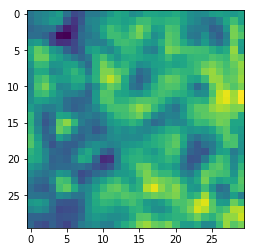

In [10]:
class DigitalGlobeDataset(Dataset):
    """DG Dataset"""
    def __init__(self, image_dir, transform=None):
        """ 
        Args:
            image_dir(string): the folder containing the DG images
            transform (callable, optional): Optional transform to  be applies
        """
        self.image_dir = image_dir
        self.transform = transform
        self.bgrn = [1,2,4,6]
        
    
    def __getitem__(self, idx):
        img_name = glob.glob(self.image_dir + '/*.tif')[idx]
        img_arr = getDims(img_name)[1]
        
        new_shp = [4,30,30]
        img_arr = img_arr[self.bgrn,:,:] 
        img_arr = resize(img_arr, new_shp, preserve_range=True, mode='reflect')
        img_arr = img_arr / 10000
        
        if self.transform:
            img_arr = self.transform(img_arr)
        
        return img_arr
    
dg_dataset = DigitalGlobeDataset(dg_dir)
sample = dg_dataset[1]
plt.imshow(sample[0,:,:])

### create a class for planetScope data which will do the following:
1. extract the image based on an index
2. divide by the reflectance precision factor of 10000

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  from ipykernel import kernelapp as app


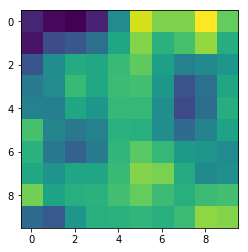

In [14]:
class PlanetScopeDataset(Dataset):
    """DG Dataset"""
    def __init__(self, image_dir, transform=None):
        """ 
        Args:
            image_dir(string): the folder containing the DG images
            transform (callable, optional): Optional transform to  be applies
        """
        self.image_dir = image_dir
        self.transform = transform
        
    
    def __getitem__(self, idx):
        img_name = glob.glob(self.image_dir + '/*.tif')[idx]
        img_arr = getDims(img_name)[1]
        
        img_arr = img_arr / 10000
        
        if self.transform:
            img_arr = self.transform(img_arr)
        
        return img_arr
    
pl_dataset = PlanetScopeDataset(planet_dir)
sample = pl_dataset[1]
plt.imshow(sample[0,:,:])

#### make a class to transform the array to a tensor, and make the dataset calls use it


In [20]:
class ToTensor(object):
    """Convert ndarrays to Tensors... 
    NOTE: rasterio has band as first dim, no need for transpose
    """
    
    def __call__(self, img_arr):
        return torch.from_numpy(img_arr)
    
pl_T_dataset = PlanetScopeDataset(planet_dir, transform=transforms.Compose([ToTensor()]))
dg_T_dataset = DigitalGlobeDataset(dg_dir, transform=transforms.Compose([ToTensor()]))

dg_T_dataset[0].shape

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  app.launch_new_instance()


(4, 30, 30)

## create model class

In [ ]:
class Net(nn.Module):
    def __init__(self, upscale_factor, NUMBER_OF_BANDS):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(NUMBER_OF_BANDS, 64, (5, 5), (1, 1), (2, 2))      # Here 
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, ((NUMBER_OF_BANDS) * (upscale_factor ** 2)),  # And here
                               (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal(self.conv4.weight)

## define the model for this case
model = Net(upscale_factor=3, NUMBER_OF_BANDS=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.01) # learning rate is 0.01

cuda = torch.cuda.is_available()
if cuda:
    model.cuda()
    criterion.cuda()

## define the DataLoaders for training, testing, and validation 
#### (training_data_loader, test_data_loader, and val_data_loader)

### use the PyTorch super-resolution example for training

In [ ]:
def train(epoch, training_list, input_dataset, target_dataset):  # updated to include list of inds, Datasets
    epoch_loss = 0
#     for iteration, batch in enumerate(training_data_loader, 1):
#         input, target = Variable(batch[0]), Variable(batch[1])
        
    random.shuffle(training_list) # shuffle the list
    for iteration, ind in enumerate(training_list)
        input, target = Variable(input_dataset[ind].unsqueeze(0).float()), \
                        Variable(target_dataset[ind].unsqueeze(0).float())
        
        if cuda:
            input = input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.data[0]
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_list), loss.data[0]))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_list))


def test(testing_list, input_dataset, target_dataset):
    avg_psnr = 0
#     for batch in testing_data_loader:
#         input, target = Variable(batch[0]), Variable(batch[1])
        
        random.shuffle(testing_list)
        for iteration, ind in enumerate(testing_list)
          input, target = Variable(input_dataset[ind].unsqueeze(0).float()), \
                        Variable(target_dataset[ind].unsqueeze(0).float())
          if cuda:
            input = input.cuda()
            target = target.cuda()

        prediction = model(input)
        mse = criterion(prediction, target)
        psnr = 10 * log10(1 / mse.data[0])
        avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


def checkpoint(epoch):
    model_out_path = "/media/jomc9287/Data/pytorch_SSIR_jdiaz/pytorch_outputs/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

# define the number of epochs
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train(epoch, train_list, pl_T_dataset, dg_T_dataset)
    test(test_list, pl_T_dataset, dg_T_dataset)
    checkpoint(epoch)

In [9]:
## read the data for all of the files
# training_pl = [getDims(f) for f in planet_files[:train_len+1]]
# test_pl = [getDims(f) for f in planet_files[train_len:train_len + test_len + 1]]
# validation_pl = [getDims(f) for f in planet_files[train_len + test_len:]]

# training_dg = [getDims(f) for f in dg_files[:train_len+1]]
# test_dg = [getDims(f) for f in dg_files[train_len:train_len + test_len + 1]]
# validation_dg = [getDims(f) for f in dg_files[train_len + test_len:]]

/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  
/home/jomc9287/anaconda3/envs/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  import sys


In [10]:
## need to extract the BGRN bands from the DG arrays
# bgrn = [1,2,4,6]
# training_dg_arr = [tup[1][bgrn,:,:] for tup in training_dg]
# test_dg_arr = [tup[1][bgrn,:,:] for tup in test_dg]
# validation_dg_arr = [tup[1][bgrn,:,:] for tup in validation_dg]

In [ ]:
## then, need to resize DG arrays to planet array shapes
# pl_shp = training_pl[0][1].shape
# upscale_factor = 3
# new_shp = (pl_shp[0], pl_shp[1]*upscale_factor, pl_shp[2]*upscale_factor)
# training_dg_rs = [resize(im, new_shp, preserve_range=True, mode='reflect') for im in training_dg_arr]
# test_dg_rs = [resize(im, new_shp, preserve_range=True, mode='reflect') for im in test_dg_arr]
# validation_dg_rs = [resize(im, new_shp, preserve_range=True, mode='reflect') for im in validation_dg_arr]

In [19]:
## extract the planet arrays
# training_pl_arr = [tup[1] for tup in training_pl]
# test_pl_arr = [tup[1] for tup in test_pl]
# validation_pl_arr = [tup[1] for tup in validation_pl]

### need to normalize the data in the array by something... max()? Maximum bit value, e.g., 2^11?

In [35]:
# scale_factor = 10000 # this is used to normalize to surface reflectance as per file metadata
# trX = torch.from_numpy(np.asarray(training_pl_arr).astype('float')) / scale_factor
# trY = torch.from_numpy(np.asarray(training_dg_rs).astype('float')) / scale_factor

# teX = torch.from_numpy(np.asarray(test_pl_arr).astype('float')) / scale_factor
# teY = torch.from_numpy(np.asarray(test_dg_rs).astype('float')) / scale_factor

# valX = torch.from_numpy(np.asarray(validation_pl_arr).astype('float')) / scale_factor
# valY = torch.from_numpy(np.asarray(validation_dg_rs).astype('float')) / scale_factor

In [62]:
## test the model
# testing = valX[0].unsqueeze(0) # the .unsqueeze(0) ensure batch dim == 1, eg., [1,bands,rows,cols]
# testing = Variable(testing)
# testing = testing.float()
# output = model(testing)
# print(output.size())

# # visualize it
# arr_random = output.data.numpy()
# arr_random = arr.squeeze()
# # plt.imshow(arr[0,:,:])

torch.Size([1, 4, 30, 30])
